In [1]:
import sklearn.tree
import sklearn.model_selection

import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This is the helper function file that goes along with the tutorial
# Make sure 'tree_tutorial.py' is in your working director
from tree_tutorial import *

# Tree Based Methods

Tree based methods "bin" or "partition" the feature feature space into regions by recursively dividing the dataset with axis-aligned splits. Each region is assigned a single class or value in order to minimize an impurity metric  and the axis-aligned splits are chosen to minimize this metric for the current iteration. This method of growing decision and regression trees is called "greedy", because while an optimal split is generated in each iteration the sequence of splits learned in this manner is not guaranteed to be globally optimal by any metric. However, the tree-based are popular in many applications due to their simplicity and flexibility.

This tutorial will demostrate use of decision and regression trees from the sci-kit learn library on a series of toy datasets. The purpose of these datasets is to build intuition for the strengths and weaknesses of these methods through visualization the partitions they learn. Additionally, the process will demonstrate the neccessity of carefully selecting parameters which constrain the flexibility of the trees fit to data in order to avoid overfitting.

# Regression Trees

When growing regression trees, a common metric used to determine the impurity of a node is the mean squared error (MSE). According to this metric, for a given region $\hat{R}_m$ of the feature space we want to choose the predicted value $\hat{c}_m$ assigned to all data in that region to be the average of the observations in that region. This is easily seen since

\begin{align*}
\hat{c}_m = \arg\min_c \sum_{i: x_i \in \hat{R}_m} (y_i - c)^2 \implies \hat{c} = \frac{\sum_{i: x_i \in \hat{R}_m} y_i}{\#{x_i \in \hat{R}_m}}.
\end{align*}

This means that the function learned $\hat{f}(x)$ learned by a regression tree can be expressed as a sum of indicators. Formally, let $\hat{R}_1,\cdots, \hat{R}_M$ be the regions defined by the $M$ leaves and $\hat{c}_1, \cdots, \hat{c}_M$ be the predicted value in each leaf as defined above, then we may express

\begin{align*}
\hat{f}(x) = \sum_{m=1}^M \hat{c}_m I(x \in \hat{R}_m).
\end{align*}

Accordingly, this would indicate that regression trees excel in situations where data belongs to clusters and the observations within clusters take on the same (or similar values). However, it is also important to note that regression trees can perform very poorly when modeling continuous functions or if the clusters are not easily assigned to regions with axis aligned splits.

## Axis-Aligned Splits

To cement this intuition, we generate artificial data from a generative model where regression trees should excel. Specifically, we choose 5 regions $R_1, \cdots, R_5$ which partition the features space $[0,1]\times [0,1]$ and values $c_1, \cdots, c_5$ that the data in each region will be generated from and then sample data according to

\begin{align*}
x_i &\sim \text{unif}([0,1]\times [0,1])\\
\epsilon_i &\sim \mathcal{N}(0,1)\\
y_i &= \sum_{m=1}^5 c_m I(x \in R_m) + \epsilon_i.
\end{align*}

A sample dataset and the ground truth model it was generated from are shown below.

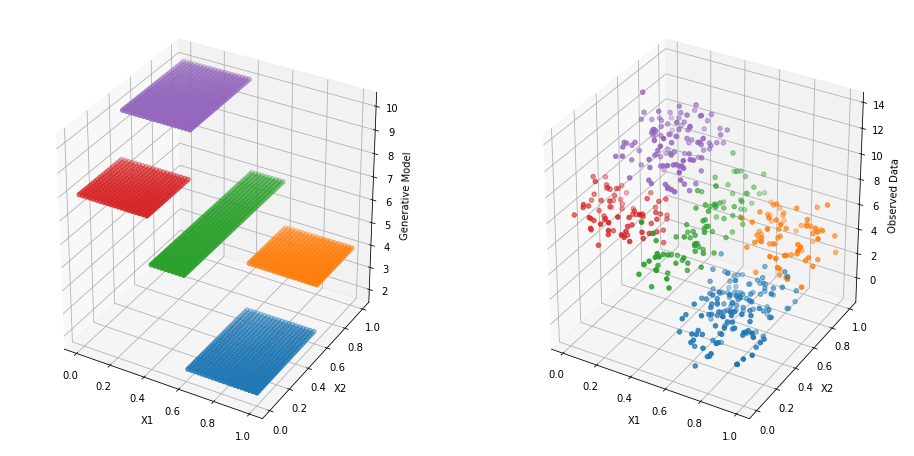

In [2]:
X, y_obs, y_true = generate_regression_dataset(n=500, plot=True)

This should be a problem regression trees are well suited to, so let's see how these models perform out of the box (using the default parameters for everything).

In [3]:
regression_tree = sklearn.tree.DecisionTreeRegressor().fit(X, y_obs)

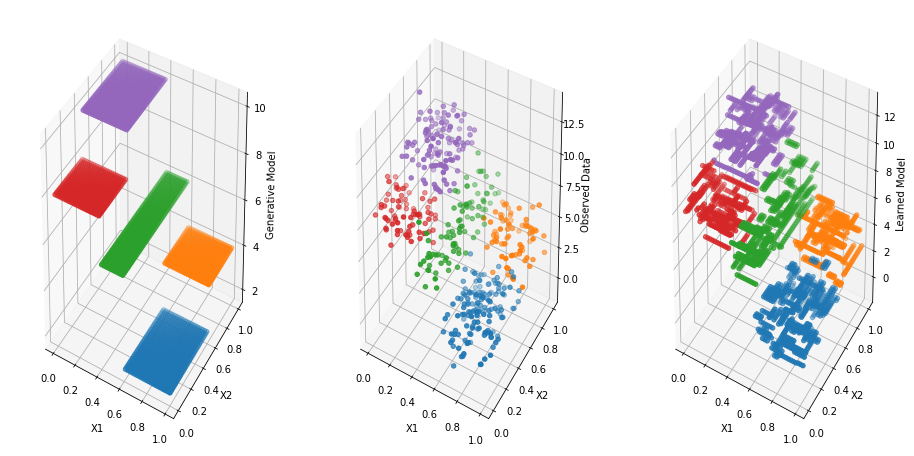

In [4]:
plot_tree(regression_tree, X, y_obs, y_true)

Unsurprisingly, this does not work very as we have drastically overfit the data. The reason for this is that the default parameters allow the tree to grow maximally deep meaning that only a small number of observations are assigned to each leaf. As such, the predicted values in each region are highly sensitive to the noise. 

As such, we will need choose new parameters to control the flexibility of the model by restricting the number of splits made. As with many of the methods we have seen in this class, we will choose the values of these hyperparameters via cross validate over range of reasonable value. Specifically, we will adjust ```max_depth``` and ```max_leaf_nodes``` . Choosing to seach over both of these paramers is fairly redundant, since they restrict how deep the tree can be grown in a very similar way. However, decision trees have many hyperparameters to regulate the bias/variance all of which restrict how deep the tree is permitted to grow in a very similar. As such, use these two parameters to demonstrate this point.

In [5]:
leaf_params = np.arange(2,10)
depth_params = np.arange(1,10)
params = np.transpose([np.tile(leaf_params, len(depth_params)),
                       np.repeat(depth_params, len(leaf_params))])
k_folds = 5
neg_mses = np.zeros((len(leaf_params), len(depth_params), k_folds))
for max_leaf_nodes, max_depth in params:
    regression_tree = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth,
                                                         max_leaf_nodes=max_leaf_nodes)
    neg_mse = sklearn.model_selection.cross_val_score(regression_tree, X, y_obs, cv=k_folds, 
                                                      scoring='neg_mean_squared_error')
    neg_mses[leaf_params == max_leaf_nodes,depth_params == max_depth, :] = neg_mse

As expected below, we see evidence that these parameters are redundant as a result of the bandedness in the heatmap. Specifically, notice that the performance is similar for all ```max_depths``` given a single ```max_leaf_nodes``` so long as the tree is permitted to grow "deep enough". We also see that the best performance was achieved with a capable of learning 5 regions, this is what we would expect and hope for since that is the same number of regions as in our generative model. Moreover, notice that the performance for trees with fewer than $5$ regions is significantly worse than trees with greater than $5$ regions. This also makes sense since we would expect that the overfitting caused by allowing an extra region to be learned is drastically less harmful than entirely missing a region.

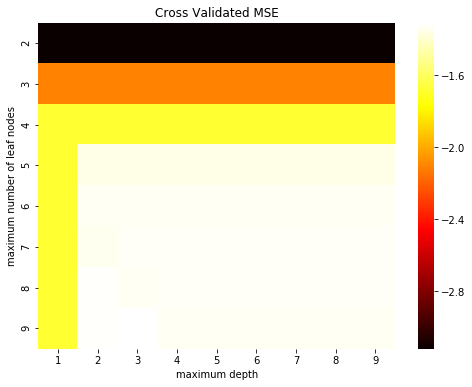

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8 ,6))
im = seaborn.heatmap(pd.DataFrame(np.mean(neg_mses, axis=-1),
                                  columns=depth_params,
                                  index=leaf_params),
                     cmap="hot")
ax.set_title('Cross Validated MSE')
ax.set_xlabel('maximum depth')
ax.set_ylabel('maximum number of leaf nodes')
plt.show()

We can now use the hyperparameters selected by cross validation to retrain the model and compare it tto the generative model.

In [7]:
ind = np.unravel_index(np.argmax(np.mean(neg_mses, axis=-1)), dims=neg_mses.shape[:-1])
regression_tree = sklearn.tree.DecisionTreeRegressor(max_depth=depth_params[ind[1]],
                                                     max_leaf_nodes=leaf_params[ind[0]]).fit(X, y_obs)

Note than the regression tree now performs very well on this dataset and recovers the generative model. This is what we would expect since we designed the generative model to be well suited for regression trees. However, this is still a useful demonstration  of how prone regression trees are to overfitting and the importantance of cross validation/restricting tree depth.

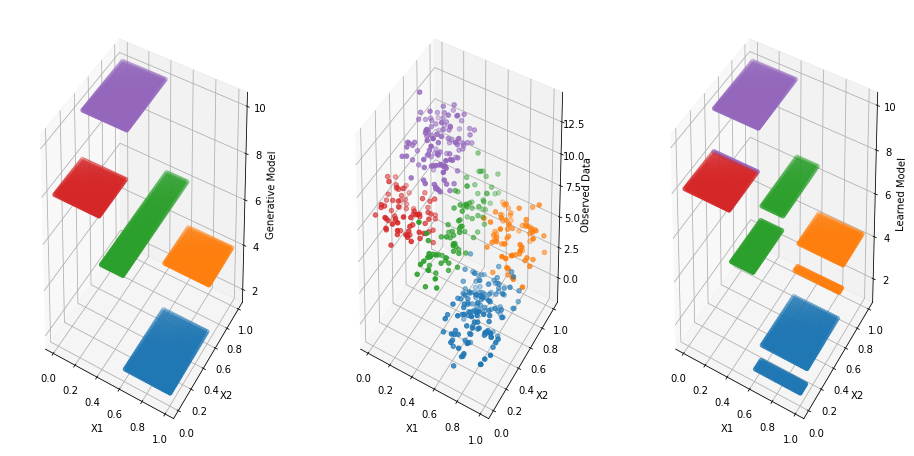

In [8]:
plot_tree(regression_tree, X, y_obs, y_true)

# Non axis aligned splits

To demonstrate another assumption made when applying regression trees, we generate another dataset according to the same process. However, now we only use $4$ regions and choose these regions so that their boundaries are not axis-aligned. A sample dataset and generative model is shown below.

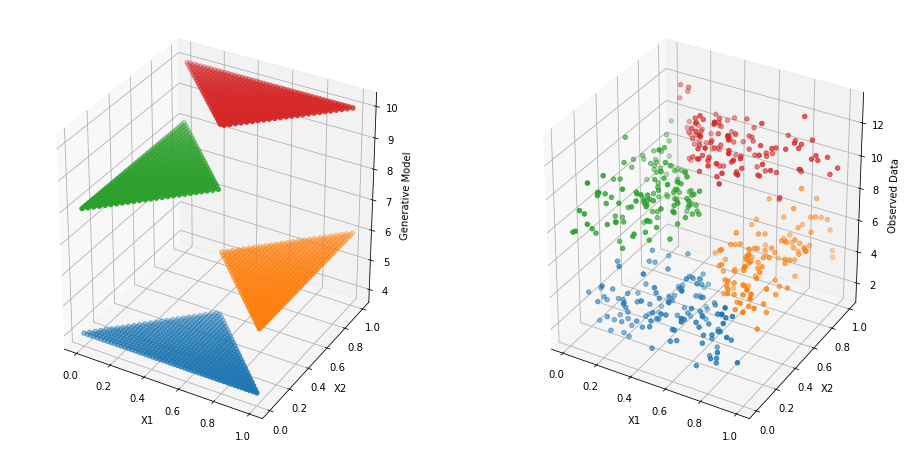

In [9]:
X, y_obs, y_true = generate_regression_dataset(n=500, plot=True, model='diagonal_step')

One approach to try and fit these diagonal boundaries is to once again allow the decision tree to grow maximally deep. The hope here is that it will be capable of generating many splits close to the true boundary closely aproxmating the boundary. However, we see this is ineffective and once again the model simply overfits the noise.

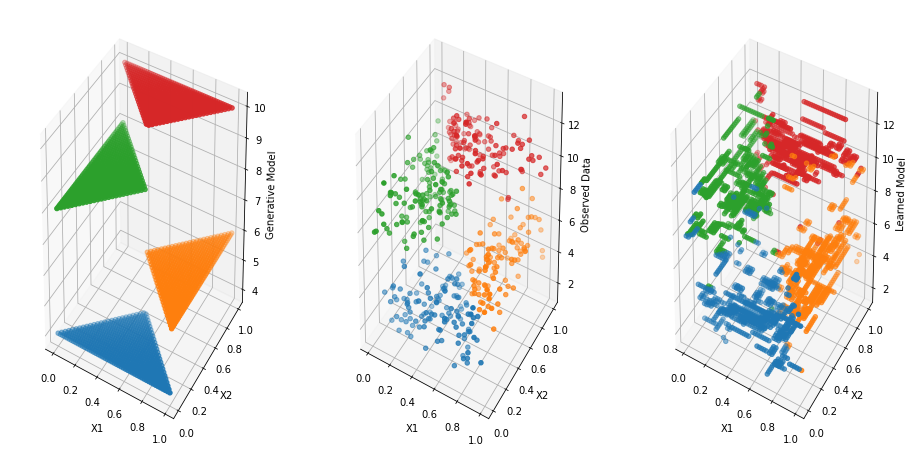

In [10]:
regression_tree = sklearn.tree.DecisionTreeRegressor().fit(X, y_obs)
plot_tree(regression_tree, X, y_obs, y_true, model='diagonal_step')

However, if we restrict the flexibility of the model it is still incapable of learning an effective set of partitions. Try running the cell below for many values of ```max_leaf_nodes``` to get a feel for how the regression tree behaves in this scenario. 

In [11]:
regression_tree = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes=30).fit(X, y_obs)

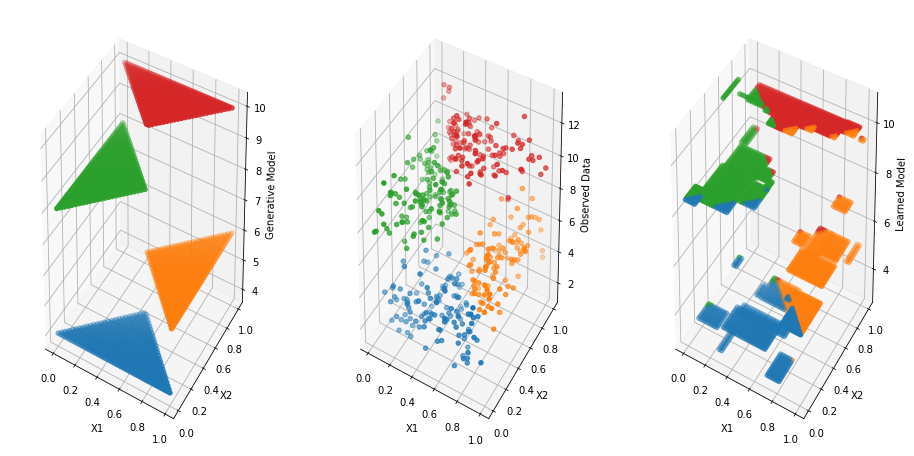

In [12]:
plot_tree(regression_tree, X, y_obs, y_true, model='diagonal_step')

## Exercise:
How might you address the above limitations? See if you can find a solution that works well on this toy dataset.

some initial ideas to try:
 - make a series of affine splits
 - consider rotations of your dataset

# Classification Trees

Classification trees behave similarly to regression trees with the exception that they consider different metric to measure the impurity of nodes at each split. Cross-entropy and the Gini index are two such metrics that are commonplace and perform similarly. Additionally, the observations in each region are assigned a probability for each class label instead of a value. These probability assigned for a given class is the $\%$ of observations in the region which belong to that class. In this way, decision trees easily handle multi-class classification problems.

# Simulated Data: Visualizing Decision Boundaries

Similar to regression trees, decision trees excel when classes can be well separated by a recursive series of axis aligned splits. The nature of these recursive splits enable decisions trees to learn many types of complicated, non-linear boundaries. However, this feature also makes them sensitive to overfitting. Below, we demonstrate 3 toy classification scenarios and visualize the type of decision rules learned by decision trees. Please try running each cell for a couple values of the given hyperparameter and notice how the decision boundaries change

To start, we generate a simple linear classification scenario with a small amount of noise. Note than in the plots below, 10% of the dataset is held out from the fitting model as "testing" data so that you can see how the model performs while predicting the labels for these held out data. The "testing" data can be recognized as the points which are faded.

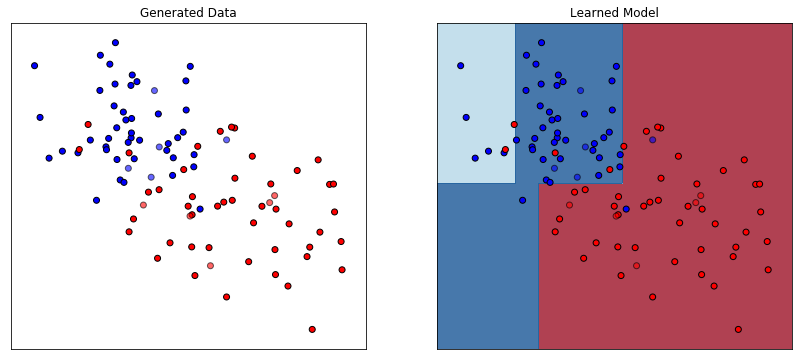

In [13]:
X, y = generate_classification_dataset(100, model='affine')
classification_tree = sklearn.tree.DecisionTreeClassifier(max_depth=3)
plot_classification_tree(classification_tree, X, y)
plt.show()

Next, we consider a scenario where the decision boundary is a circle around the origin. Again, please run the cell multiple times to get a feel for how stable the decision boundary is and how it performs ont eh held out data.

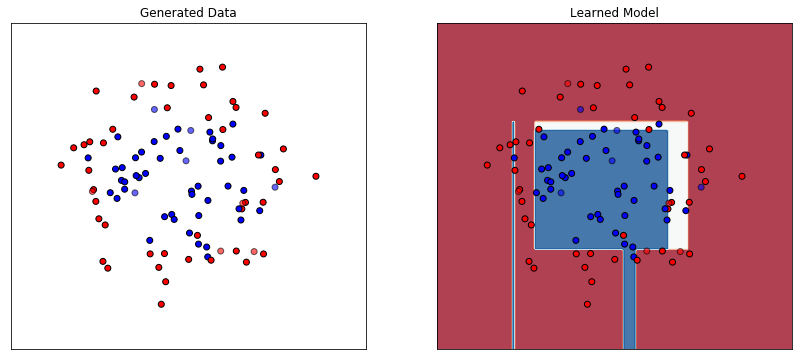

In [14]:
X, y = generate_classification_dataset(100, model='circles')
classification_tree = sklearn.tree.DecisionTreeClassifier(max_depth=5)
plot_classification_tree(classification_tree, X, y)
plt.show()

Finally, we consider an even more complicated non-linear boundary consisting of two inter-twined cresents.

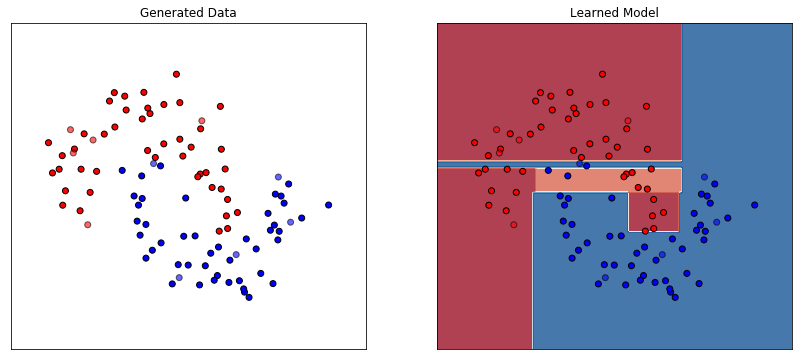

In [15]:
X, y = generate_classification_dataset(100, model='moons')
classification_tree = sklearn.tree.DecisionTreeClassifier(max_depth=5)
plot_classification_tree(classification_tree, X, y)
plt.show()

# Iris Dataset: Visualizing Classification Rules

Finally, we perform classification on a real dataset and demonstrate how higher-dimensional decision rules can be interpreted and visualized.

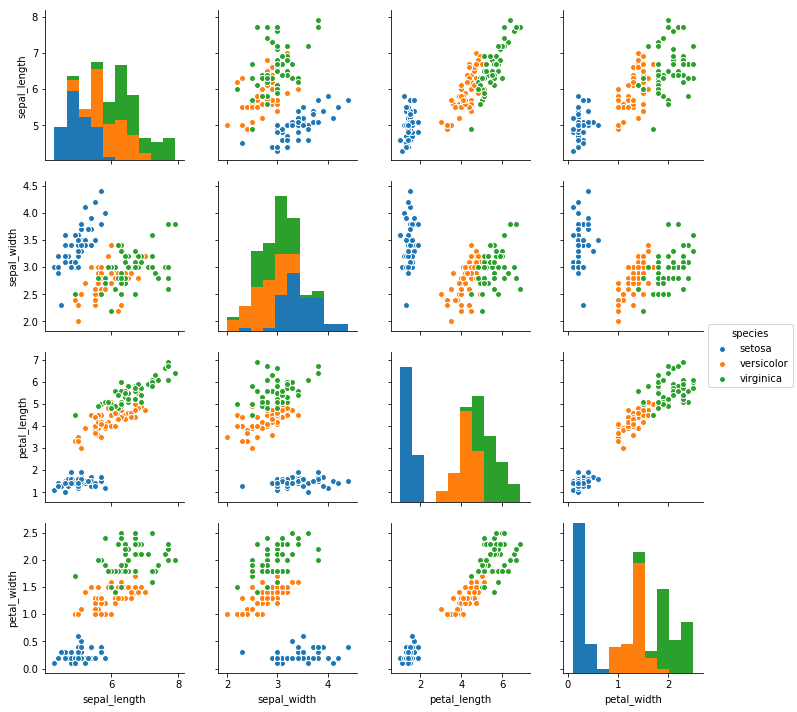

In [16]:
iris = seaborn.load_dataset("iris")
seaborn.pairplot(iris, hue="species")
plt.show()

In order to avoid overfitting, we will once again cross validate over a range of hyperparameters which limit tree depth.

In [17]:
# Format Data
X = np.array(iris)[:,:-1]
encoder = sklearn.preprocessing.LabelEncoder()
y = encoder.fit_transform(np.array(iris)[:,-1])

# Cross Validate Over Hyperparameters
scores = np.zeros((len(leaf_params), len(depth_params), k_folds))
for max_leaf_nodes, max_depth in params:
    regression_tree = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth,
                                                          max_leaf_nodes=max_leaf_nodes)
    score = sklearn.model_selection.cross_val_score(regression_tree, X, y, cv=k_folds)
    scores[leaf_params == max_leaf_nodes,depth_params == max_depth, :] = score

Note that we see a very similar pattern as before. Once again, it appears that allowing a little bit of "extra" flexibility in the model is less harmful than not allowing "enough" flexibility to properly separate all three classes.

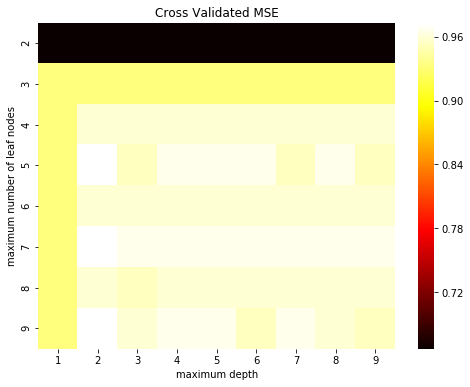

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8 ,6))
im = seaborn.heatmap(pd.DataFrame(np.mean(scores, axis=-1),
                                  columns=depth_params,
                                  index=leaf_params),
                     cmap="hot")
ax.set_title('Cross Validated MSE')
ax.set_xlabel('maximum depth')
ax.set_ylabel('maximum number of leaf nodes')
plt.show()

Once we get past $2$ dimensions it is difficult to visualize decision boundaries and the parameters in a decision tree are not as readily interpretable as coefficients in a logistic regression. However, the decision rules learned by tree-based methods can be visualized in as a tree. This can be desirable in some applications as it provides a clear decision making process that is more easily understood and followed by practitioners in other fields.

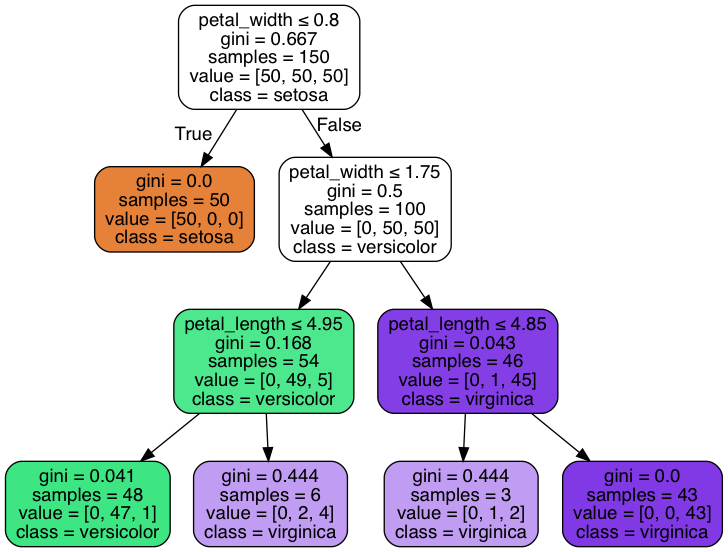

In [19]:
ind = np.unravel_index(np.argmax(np.mean(scores, axis=-1)), dims=scores.shape[:-1])
classification_tree = sklearn.tree.DecisionTreeClassifier(max_depth=depth_params[ind[1]],
                                                          max_leaf_nodes=leaf_params[ind[0]]).fit(X, y)
show_tree_graph(classification_tree, features=iris.columns[:-1], labels=np.unique(np.array(iris)[:,-1]))

However, one must take great care when interpreting these types of decision rules. Due to the greedy nature of the tree-growing algorithm, the learned sequence of rules can be highly unstable and change dramatically with even slight perturbations of the data. For example, run the cell below multiple times. Each time it is run, a new tree will be fit to a subset of the training data and a decision graph generated for this fit. Take note wide variety of decision rules presented for the same dataset.

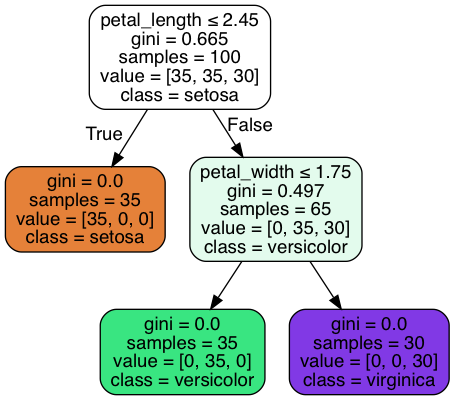

In [20]:
idx = npr.choice(np.arange(150), size=100)
classification_tree = sklearn.tree.DecisionTreeClassifier(max_depth=depth_params[ind[1]],
                                                          max_leaf_nodes=leaf_params[ind[0]]).fit(X[idx,:], y[idx])
show_tree_graph(classification_tree, features=iris.columns[:-1], labels=np.unique(np.array(iris)[:,-1]))